# Boruta Feature Importance

Про способ: https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

In [52]:
from abc import ABC, abstractmethod
import copy

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.inspection import permutation_importance

from lightgbm import LGBMClassifier

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import shap

from BorutaShap import BorutaShap

import warnings
warnings.filterwarnings('ignore')

In [2]:
x, y = make_classification(
    n_samples=10000,
    n_features=100,
    n_informative=15,
    n_redundant=5,
    weights=(0.95, 0.05),
    n_classes=2,
    n_repeated=5,
    n_clusters_per_class=4,
    shift=0.8,
    scale=3.0,
    shuffle=False)

In [3]:
cross_val_score(
    LGBMClassifier(verbose=-100), x, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro').mean()

0.7082634171812725

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify=y)

In [5]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [6]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2840
           1       0.97      0.24      0.38       160

    accuracy                           0.96      3000
   macro avg       0.97      0.62      0.68      3000
weighted avg       0.96      0.96      0.95      3000



# Отбор с помощью BorutaShap

In [7]:
x_train = pd.DataFrame(x_train, columns=[f'feature_{i}' for i in range(x_train.shape[1])])

In [8]:
fs_boruta = BorutaShap(
    model=LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100),
    importance_measure='shap',
    classification=True)

fs_boruta.fit(X=x_train, y=y_train, n_trials=50, random_state=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:03<00:00,  2.48s/it]

11 attributes confirmed important: ['feature_1', 'feature_4', 'feature_8', 'feature_79', 'feature_6', 'feature_0', 'feature_2', 'feature_5', 'feature_11', 'feature_12', 'feature_10']
86 attributes confirmed unimportant: ['feature_85', 'feature_74', 'feature_76', 'feature_88', 'feature_18', 'feature_59', 'feature_71', 'feature_32', 'feature_96', 'feature_46', 'feature_29', 'feature_38', 'feature_26', 'feature_67', 'feature_52', 'feature_3', 'feature_45', 'feature_23', 'feature_94', 'feature_16', 'feature_21', 'feature_86', 'feature_51', 'feature_20', 'feature_49', 'feature_17', 'feature_66', 'feature_28', 'feature_27', 'feature_58', 'feature_93', 'feature_68', 'feature_50', 'feature_47', 'feature_95', 'feature_61', 'feature_73', 'feature_81', 'feature_84', 'feature_77', 'feature_64', 'feature_9', 'feature_63', 'feature_97', 'feature_31', 'feature_78', 'feature_57', 'feature_24', 'feature_35', 'feature_60', 'feature_43', 'feature_48', 'feature_33', 'feature_89', 'feature_92', 'feature_90

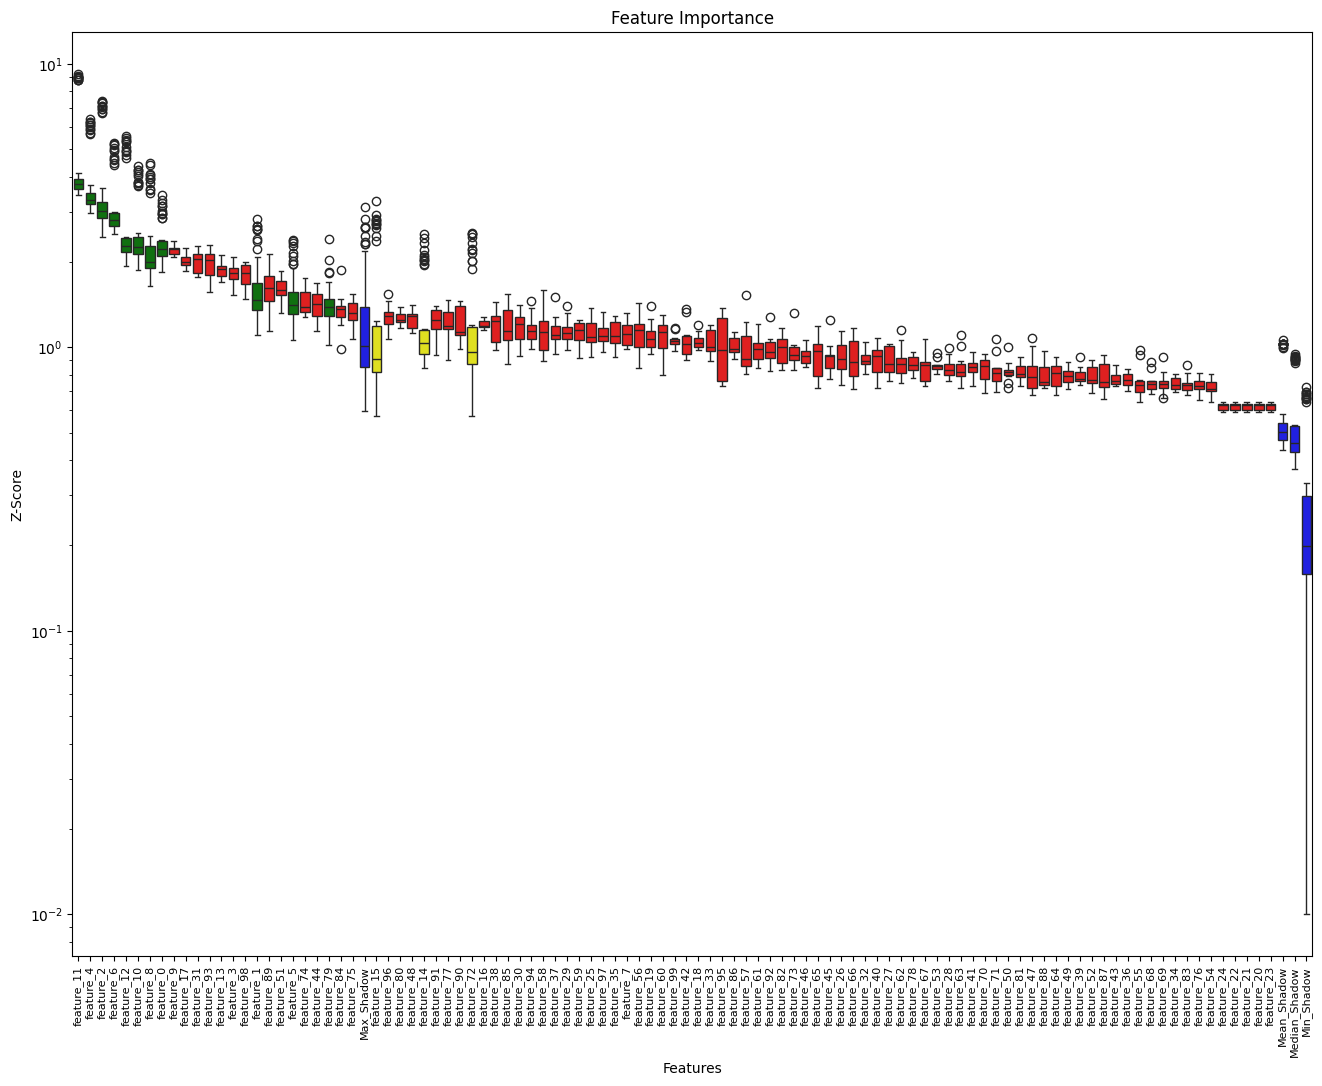

In [11]:
fs_boruta.plot(which_features='all', figsize=(16, 12))

In [12]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train[fs_boruta.accepted], y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [13]:
x_val = pd.DataFrame(x_val, columns=[f'feature_{i}' for i in range(x_val.shape[1])])

In [14]:
print(classification_report(y_val, model.predict(x_val[fs_boruta.accepted])))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2840
           1       0.86      0.36      0.50       160

    accuracy                           0.96      3000
   macro avg       0.91      0.68      0.74      3000
weighted avg       0.96      0.96      0.96      3000



# Vanilla

## Сначала создадим копии всех признаков, перешая значения в них, это будут теневые признаки

In [19]:
shadow_x = x_train.apply(np.random.permutation)
shadow_x.columns = ['shadow_'+col for col in shadow_x.columns]
shadow_x.head()

,shadow_feature_0,shadow_feature_1,shadow_feature_2,shadow_feature_3,shadow_feature_4,shadow_feature_5,shadow_feature_6,shadow_feature_7,shadow_feature_8,shadow_feature_9,...,shadow_feature_90,shadow_feature_91,shadow_feature_92,shadow_feature_93,shadow_feature_94,shadow_feature_95,shadow_feature_96,shadow_feature_97,shadow_feature_98,shadow_feature_99
0,-9.103803,-6.510469,4.012235,13.989281,-12.562109,8.648470,0.291413,8.041604,2.164326,3.783481,...,1.417680,-3.899675,0.856464,2.037382,2.668215,2.887091,3.116444,0.143887,1.295805,7.376207
1,8.046436,-2.790032,3.555243,7.263791,3.804703,2.412002,3.925176,3.733354,6.231635,0.938239,...,6.350571,-1.579367,2.302414,-4.647766,0.751961,10.627104,4.595147,6.639962,1.188366,-1.784877
2,5.945580,-13.345209,9.078174,-3.024366,-4.105406,-0.838684,15.369042,16.168455,-1.134780,13.584621,...,5.061237,-1.838742,4.139956,5.189579,0.627217,4.205423,7.984847,1.105637,1.106014,0.173217
3,13.508087,-3.960814,-0.140697,9.970617,-2.543720,-1.789342,12.176759,5.499550,-2.850412,-4.679179,...,2.818589,2.863573,2.680006,7.317878,6.481907,-1.733432,3.951335,2.443632,0.713104,-2.108791
4,-10.908691,-16.287060,12.205244,-15.554781,10.269156,-5.208870,-5.974461,10.371525,13.218881,7.698857,...,-0.382288,1.992133,5.251081,-1.905744,0.638788,-0.942111,0.273424,0.723932,4.040002,5.529714


In [22]:
x_train_boruta = pd.concat([x_train, shadow_x], axis=1)
x_train_boruta.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,shadow_feature_90,shadow_feature_91,shadow_feature_92,shadow_feature_93,shadow_feature_94,shadow_feature_95,shadow_feature_96,shadow_feature_97,shadow_feature_98,shadow_feature_99
0,7.039615,3.886134,-1.881213,19.058090,7.496074,-0.846889,-12.137040,-4.423717,-14.408564,15.697875,...,1.417680,-3.899675,0.856464,2.037382,2.668215,2.887091,3.116444,0.143887,1.295805,7.376207
1,6.718789,-4.026466,-9.164948,-0.804444,-6.055426,8.973674,8.668155,4.150073,5.966492,2.007946,...,6.350571,-1.579367,2.302414,-4.647766,0.751961,10.627104,4.595147,6.639962,1.188366,-1.784877
2,-0.701885,-11.913876,0.529151,-5.238706,-3.633387,5.312086,-0.533111,0.680523,-6.577791,6.754491,...,5.061237,-1.838742,4.139956,5.189579,0.627217,4.205423,7.984847,1.105637,1.106014,0.173217
3,-2.693342,1.413612,5.042347,-0.107101,-1.064879,-2.523532,-0.447320,7.579628,-0.215127,7.279811,...,2.818589,2.863573,2.680006,7.317878,6.481907,-1.733432,3.951335,2.443632,0.713104,-2.108791
4,-1.195109,6.371532,6.317107,-3.988815,11.305561,-10.080775,-5.121705,12.060138,4.379787,7.846646,...,-0.382288,1.992133,5.251081,-1.905744,0.638788,-0.942111,0.273424,0.723932,4.040002,5.529714


## Обучим любую модель, которая может выдавать важности признаков на получившемся датасете

In [23]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train_boruta, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [25]:
# запишем важности признаков, отдельно для настоящих и для теневых

feat_imps = model.feature_importances_[:x_train.shape[1]]
feat_imps_shadow = model.feature_importances_[x_train.shape[1]:]

In [30]:
len(feat_imps), len(feat_imps_shadow)

(100, 100)

In [43]:
hits_stats = pd.DataFrame(np.zeros(shape=(1, x_train.shape[1])), index=['hits'], columns=x_train.columns)
hits_stats

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
hits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# в качестве порога важности выбираем максимум из значений важности признаков для теневых признаков, посмотрим какие признаки попали

hits = feat_imps > feat_imps_shadow.max()
hits

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False])

In [45]:
hits_stats += hits
hits_stats

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
hits,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# получили список признаков, которые удовлетворяют условию, неплохо, но не случайность ли это?
hits_stats.loc['hits'][hits_stats.loc['hits'] == 1]

feature_0     1.0
feature_1     1.0
feature_2     1.0
feature_3     1.0
feature_4     1.0
feature_5     1.0
feature_6     1.0
feature_7     1.0
feature_8     1.0
feature_9     1.0
feature_10    1.0
feature_11    1.0
feature_12    1.0
feature_13    1.0
feature_14    1.0
feature_15    1.0
feature_16    1.0
feature_17    1.0
feature_18    1.0
feature_19    1.0
feature_48    1.0
feature_93    1.0
Name: hits, dtype: float64

In [53]:
# повторим всю процедуру n количество раз

hits_stats = pd.DataFrame(np.zeros(shape=(1, x_train.shape[1])), index=['hits'], columns=x_train.columns)  # для записи статистики

for i in tqdm(range(50)):
    # создадим датасет
    shadow_x = x_train.apply(np.random.permutation)
    shadow_x.columns = ['shadow_'+col for col in shadow_x.columns]
    x_train_boruta = pd.concat([x_train, shadow_x], axis=1)

    # обучим модель
    model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
    model.fit(x_train_boruta, y_train)

    feat_imps = model.feature_importances_[:x_train.shape[1]]
    feat_imps_shadow = model.feature_importances_[x_train.shape[1]:]

    hits = feat_imps > feat_imps_shadow.max()
    hits_stats += hits

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.68s/it]


In [54]:
# получили статистики по испытаниям

hits_stats

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
hits,49.0,50.0,50.0,50.0,50.0,50.0,50.0,42.0,50.0,50.0,...,0.0,0.0,1.0,5.0,0.0,0.0,1.0,3.0,0.0,4.0


In [61]:
# с какой вероятностью мы в схеме испытаний Бернулли получим ровно 5 выигрышей, если вероятность успеха 0.5?

from math import comb

comb(50, 5) * (0.5)**5*(0.5)**45

1.8818369085238373e-09

In [62]:
# аналогично
from scipy import stats as sts
sts.binom.pmf(5, 50, .5)

1.8818369085238336e-09

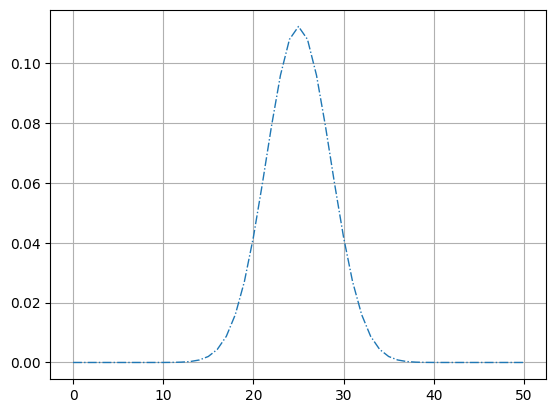

In [96]:
# построим биномиальное распределение
pmf = [sts.binom.pmf(x, 50, .5) for x in range(51)]
plt.plot(pmf, '-.', lw=1)
plt.grid(True);

In [79]:
# получается те испытания, которые попали в левый хвост явно отбрасываются, те, которые в правый точно остаются, остальные непонятные
sts.binom.ppf(0.05, 50, .5), sts.binom.ppf(0.95, 50, .5)

# в нашем случае, все, что меньше 19 выкидывается, все, что больше 31 остается

(19.0, 31.0)

In [80]:
pmf[:19]

[8.881784197001225e-16,
 4.440892098500617e-14,
 1.0880185641326562e-12,
 1.7408297026122545e-11,
 2.0454749005693812e-10,
 1.8818369085238336e-09,
 1.4113776813928759e-08,
 8.871516854469482e-08,
 4.768440309277364e-07,
 2.2252721443294427e-06,
 9.123615791750715e-06,
 3.317678469727518e-05,
 0.00010782455026614458,
 0.00031517945462411566,
 0.0008329742729351619,
 0.001999138255044387,
 0.004373114932909585,
 0.008746229865819168,
 0.016034754754001845]

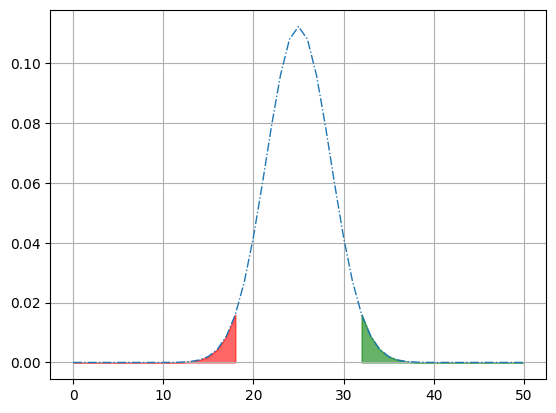

In [97]:
pmf = [sts.binom.pmf(x, 50, .5) for x in range(51)]
plt.plot(pmf, '-.', lw=1, )
plt.fill_between(range(19), pmf[:19], color='red', alpha=0.6)
plt.fill_between(range(32, 51), pmf[32:], color='green', alpha=0.6)
plt.grid(True);

In [101]:
hits_stats.loc['hits'][hits_stats.loc['hits'] > 31]

feature_0     49.0
feature_1     50.0
feature_2     50.0
feature_3     50.0
feature_4     50.0
feature_5     50.0
feature_6     50.0
feature_7     42.0
feature_8     50.0
feature_9     50.0
feature_10    50.0
feature_11    50.0
feature_12    50.0
feature_13    50.0
feature_14    50.0
feature_15    50.0
feature_16    39.0
feature_17    45.0
feature_19    45.0
Name: hits, dtype: float64

## Можно добавить shap для оценки фичей

In [102]:
explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(x_train_boruta)

In [103]:
shap_values

array([[ 0.24784767,  0.13429119,  0.29630747, ...,  0.04963427,
        -0.0054616 ,  0.36405583],
       [ 0.2779601 , -0.42916663,  0.46374229, ..., -0.0054101 ,
         0.00619482, -0.04982499],
       [ 0.08224174, -0.36684622,  0.12509235, ...,  0.03296199,
         0.00495216,  0.14707494],
       ...,
       [ 0.35895507,  0.09442468,  0.38624848, ..., -0.03387545,
         0.0183649 ,  0.08095387],
       [ 0.27150371, -0.3086055 , -0.53079389, ...,  0.02283386,
         0.02745763,  0.14110543],
       [ 0.30398005,  0.14361876, -0.27883911, ...,  0.01908974,
        -0.00578939, -0.04710982]])

In [104]:
if isinstance(shap_values, list):
    # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
    importances = np.abs(shap_values[1]).mean(axis=0)
else:
    # if shap_values in np.array of shape [n_samples, n_features]
    importances = np.abs(shap_values).mean(axis=0)

In [107]:
importances

array([0.27736   , 0.20110711, 0.44002521, 0.11870774, 0.34193041,
       0.16830232, 0.46003587, 0.05865834, 0.27620526, 0.1042734 ,
       0.25165878, 0.58982436, 0.37223653, 0.17800706, 0.12991171,
       0.18963626, 0.04917312, 0.18268604, 0.03713114, 0.049649  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01773777, 0.11510076, 0.02644946, 0.04708346, 0.06734934,
       0.02003653, 0.09967782, 0.0204333 , 0.04123283, 0.01516162,
       0.03359627, 0.04100811, 0.07045843, 0.03532053, 0.025518  ,
       0.01723018, 0.01476085, 0.03180455, 0.02052254, 0.08331881,
       0.04122003, 0.07074438, 0.01094692, 0.06345513, 0.01138477,
       0.0122002 , 0.01517653, 0.01272486, 0.00656367, 0.00655065,
       0.01591699, 0.07995116, 0.05532168, 0.03008922, 0.02593423,
       0.0133566 , 0.03707682, 0.01514361, 0.06462586, 0.04048695,
       0.04065875, 0.048214  , 0.01636111, 0.01700974, 0.01966135,
       0.02432501, 0.05869373, 0.14094672, 0.03960252, 0.06049

In [108]:
# повторим всю процедуру n количество раз

hits_stats = pd.DataFrame(np.zeros(shape=(1, x_train.shape[1])), index=['hits'], columns=x_train.columns)  # для записи статистики

for i in tqdm(range(50)):
    # создадим датасет
    shadow_x = x_train.apply(np.random.permutation)
    shadow_x.columns = ['shadow_'+col for col in shadow_x.columns]
    x_train_boruta = pd.concat([x_train, shadow_x], axis=1)

    # обучим модель
    model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
    model.fit(x_train_boruta, y_train)

    explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
    shap_values = explainer.shap_values(x_train_boruta)

    if isinstance(shap_values, list):
        # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
        importances = np.abs(shap_values[1]).mean(axis=0)
    else:
        # if shap_values in np.array of shape [n_samples, n_features]
        importances = np.abs(shap_values).mean(axis=0)

    feat_imps = importances[:x_train.shape[1]]
    feat_imps_shadow = importances[x_train.shape[1]:]

    hits = feat_imps > feat_imps_shadow.max()
    hits_stats += hits

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:08<00:00,  3.76s/it]


In [109]:
hits_stats.loc['hits'][hits_stats.loc['hits'] > 31]

feature_0     50.0
feature_1     48.0
feature_2     50.0
feature_4     50.0
feature_5     45.0
feature_6     50.0
feature_8     50.0
feature_10    50.0
feature_11    50.0
feature_12    50.0
feature_13    42.0
feature_15    50.0
feature_17    44.0
Name: hits, dtype: float64

In [110]:
hits_stats.loc['hits'][hits_stats.loc['hits'] < 19]

feature_3      3.0
feature_7      0.0
feature_9     14.0
feature_14    11.0
feature_16     0.0
              ... 
feature_95     0.0
feature_96     0.0
feature_97     0.0
feature_98     0.0
feature_99    10.0
Name: hits, Length: 85, dtype: float64